In [32]:
!pip install mlxtend
import numpy as np
import pandas as pd
import datetime
import random

pd.set_option('display.max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

import re, string
import spacy
from spacy.matcher import PhraseMatcher

import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from mlxtend.classifier import StackingCVClassifier

You should consider upgrading via the '/opt/python/envs/default/bin/python -m pip install --upgrade pip' command.


In [33]:
whole_data=pd.read_csv('https://raw.githubusercontent.com/benvictoria17/DataAnalytics/main/dataset/Mobile%20App%20Store%20(%207200%20apps)/AppleStore.csv',index_col=0)
desc_data=pd.read_csv('https://raw.githubusercontent.com/benvictoria17/DataAnalytics/main/dataset/Mobile%20App%20Store%20(%207200%20apps)/appleStore_description.csv')
desc_data.drop(['track_name','size_bytes'],axis=1,inplace=True)
whole_data=whole_data.merge(desc_data,how='inner',on='id',).reset_index(drop=True)
id_keep=whole_data.pop('id')

In [34]:
whole_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7197 entries, 0 to 7196
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        7197 non-null   object 
 1   size_bytes        7197 non-null   int64  
 2   currency          7197 non-null   object 
 3   price             7197 non-null   float64
 4   rating_count_tot  7197 non-null   int64  
 5   rating_count_ver  7197 non-null   int64  
 6   user_rating       7197 non-null   float64
 7   user_rating_ver   7197 non-null   float64
 8   ver               7197 non-null   object 
 9   cont_rating       7197 non-null   object 
 10  prime_genre       7197 non-null   object 
 11  sup_devices.num   7197 non-null   int64  
 12  ipadSc_urls.num   7197 non-null   int64  
 13  lang.num          7197 non-null   int64  
 14  vpp_lic           7197 non-null   int64  
 15  app_desc          7197 non-null   object 
dtypes: float64(3), int64(7), object(6)
memory 

Skewness: -1.525420
Kurtosis: 0.983266


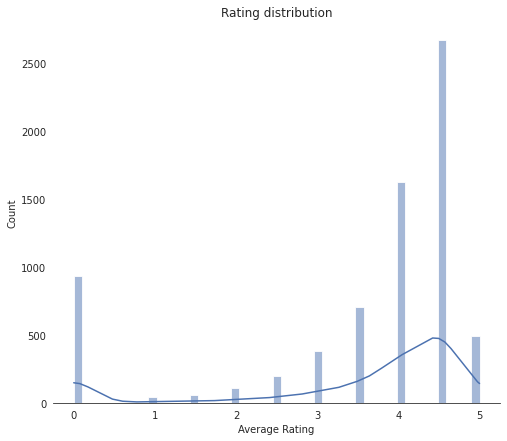

In [35]:
sns.set_style("white")
sns.set_color_codes(palette='deep')
f, ax = plt.subplots(figsize=(8, 7))
sns.histplot(whole_data['user_rating'], color="b",kde=True);
ax.xaxis.grid(False) 
ax.set(ylabel="Count")
ax.set(xlabel="Average Rating")
ax.set(title="Rating distribution")
sns.despine(left=True) 
plt.show()

print("Skewness: %f" % whole_data['user_rating'].skew()) 
print("Kurtosis: %f" % whole_data['user_rating'].kurt())

In [36]:
whole_data.head()

,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,app_desc
0,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1,Let Evernote change the way you organize your ...
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,Download the most popular free weather app pow...
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1,The eBay app is the best way to find anything ...
4,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1,On more than 250 million devices around the wo...


In [37]:
paid_data=whole_data.loc[whole_data['price']>0,:].sort_values(by=['price'],ascending=False).reset_index(drop=True)
free_data=whole_data.loc[whole_data['price']==0,:].reset_index(drop=True)
print("There are {} paid apps, taking the propotion of {}%.". format(paid_data.shape[0],round((paid_data.shape[0]/whole_data.shape[0])*100,2)))
print("There are {} free apps, taking the propotion of {}%.". format(free_data.shape[0],round((free_data.shape[0]/whole_data.shape[0])*100,2)))

There are 3141 paid apps, taking the propotion of 43.64%.
There are 4056 free apps, taking the propotion of 56.36%.


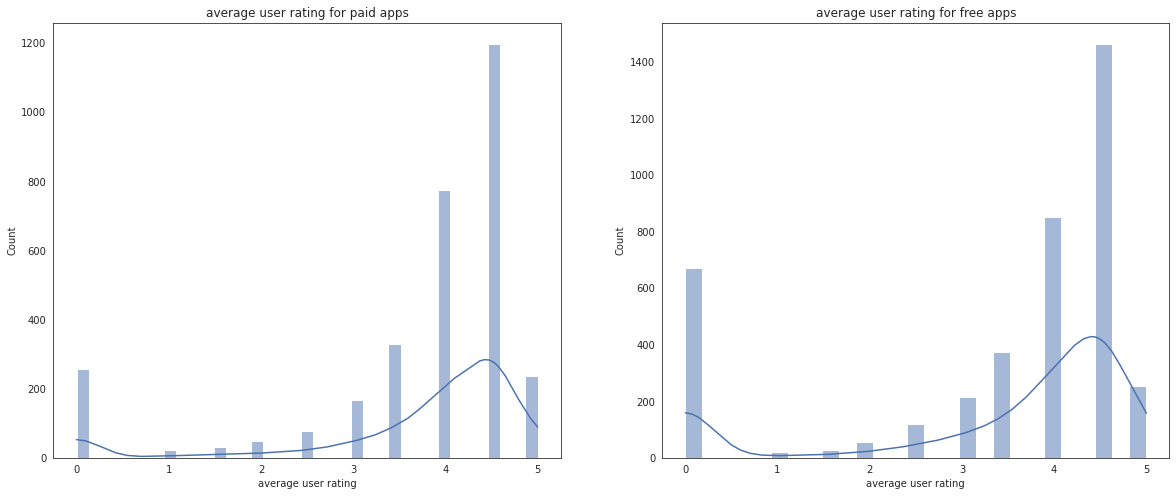

In [38]:
fig, axes = plt.subplots(1,2,figsize=(20, 8))
for data,ax in zip([paid_data,free_data],axes):
    sns.histplot(data['user_rating'], color="b",kde=True,ax=ax)
    ax.set_xlabel("average user rating")
axes[0].set_title("average user rating for paid apps")
axes[1].set_title("average user rating for free apps")

In [39]:
def generate_rating_dum(dfs):
    for data in dfs:
        data['rating01']=data['user_rating'].apply(lambda x: 1 if x>=0 and x<=1 else 0)
        data['rating12']=data['user_rating'].apply(lambda x: 1 if x>1 and x<=2 else 0)
        data['rating23']=data['user_rating'].apply(lambda x: 1 if x>2 and x<=3 else 0)
        data['rating34']=data['user_rating'].apply(lambda x: 1 if x>3 and x<=4 else 0)
        data['rating45']=data['user_rating'].apply(lambda x: 1 if x>4 and x<=5 else 0)
    
generate_rating_dum(dfs=[paid_data,free_data])
print('#'*50)
print('The ratio of ratings 0-1 for paid apps is {}%'.format(round((paid_data.rating01.sum()/paid_data.shape[0])*100,2)))
print('The ratio of ratings 1-2 for paid apps is {}%'.format(round((paid_data.rating12.sum()/paid_data.shape[0])*100,2)))
print('The ratio of ratings 2-3 for paid apps is {}%'.format(round((paid_data.rating23.sum()/paid_data.shape[0])*100,2)))
print('The ratio of ratings 3-4 for paid apps is {}%'.format(round((paid_data.rating34.sum()/paid_data.shape[0])*100,2)))
print('The ratio of ratings 4-5 for paid apps is {}%'.format(round((paid_data.rating45.sum()/paid_data.shape[0])*100,2)))
print('#'*50)
print('The ratio of ratings 0-1 for free apps is {}%'.format(round((free_data.rating01.sum()/free_data.shape[0])*100,2)))
print('The ratio of ratings 1-2 for free apps is {}%'.format(round((free_data.rating12.sum()/free_data.shape[0])*100,2)))
print('The ratio of ratings 2-3 for free apps is {}%'.format(round((free_data.rating23.sum()/free_data.shape[0])*100,2)))
print('The ratio of ratings 3-4 for free apps is {}%'.format(round((free_data.rating34.sum()/free_data.shape[0])*100,2)))
print('The ratio of ratings 4-5 for free apps is {}%'.format(round((free_data.rating45.sum()/free_data.shape[0])*100,2)))

##################################################
The ratio of ratings 0-1 for paid apps is 8.88%
The ratio of ratings 1-2 for paid apps is 2.52%
The ratio of ratings 2-3 for paid apps is 7.77%
The ratio of ratings 3-4 for paid apps is 35.15%
The ratio of ratings 4-5 for paid apps is 45.69%
##################################################
The ratio of ratings 0-1 for free apps is 17.11%
The ratio of ratings 1-2 for free apps is 2.05%
The ratio of ratings 2-3 for free apps is 8.26%
The ratio of ratings 3-4 for free apps is 30.18%
The ratio of ratings 4-5 for free apps is 42.41%


price counts for paid apps:
0.99      728
2.99      683
1.99      621
4.99      394
3.99      277
6.99      166
9.99       81
5.99       52
7.99       33
14.99      21
19.99      13
8.99        9
24.99       8
29.99       6
13.99       6
11.99       6
12.99       5
15.99       4
17.99       3
59.99       3
39.99       2
49.99       2
16.99       2
22.99       2
20.99       2
27.99       2
23.99       2
299.99      1
249.99      1
21.99       1
34.99       1
47.99       1
74.99       1
99.99       1
18.99       1
Name: price, dtype: int64


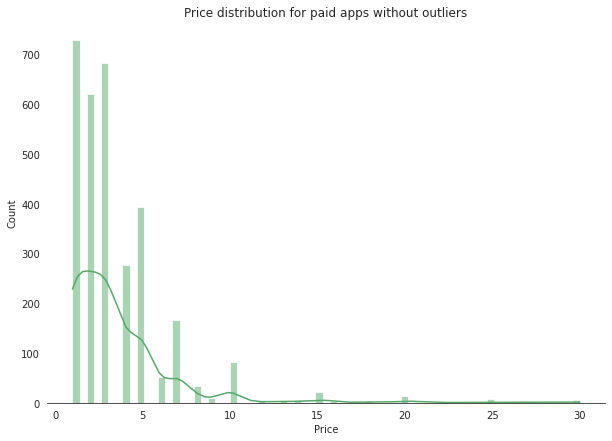

In [40]:
f, ax = plt.subplots(figsize=(20, 10))
sns.histplot(paid_data['price'], color="g",kde=True);
ax.xaxis.grid(False) 
ax.set(ylabel="Count")
ax.set(xlabel="Price")
ax.set(title="Price distribution for paid apps")
sns.despine(left=True)
plt.show()

price_counts=paid_data['price'].value_counts().sort_values(ascending=False)
print('price counts for paid apps:\n{}'.format(price_counts))
paid_data_no_outlier=paid_data.loc[paid_data['price']<30]
f, ax = plt.subplots(figsize=(10, 7))
sns.histplot(paid_data_no_outlier['price'], color="g",kde=True);
ax.xaxis.grid(False) 
ax.set(ylabel="Count")
ax.set(xlabel="Price")
ax.set(title="Price distribution for paid apps without outliers")
sns.despine(left=True) # Do not show the left axis when left=True
plt.show()

genre counts for paid apps:
Games                3862
Entertainment         535
Education             453
Photo & Video         349
Utilities             248
Health & Fitness      180
Productivity          178
Social Networking     167
Lifestyle             144
Music                 138
Shopping              122
Sports                114
Book                  112
Finance               104
Travel                 81
News                   75
Weather                72
Reference              64
Food & Drink           63
Business               57
Navigation             46
Medical                23
Catalogs               10
Name: prime_genre, dtype: int64


Genre that has the most apps is:Games,and genre that has the least apps is:Catalogs


mean ratings for each genre are:
prime_genre
Productivity         4.005618
Music                3.978261
Photo & Video        3.800860
Business             3.745614
Health & Fitness     3.700000
Games                3.685008
Weather              3.597222

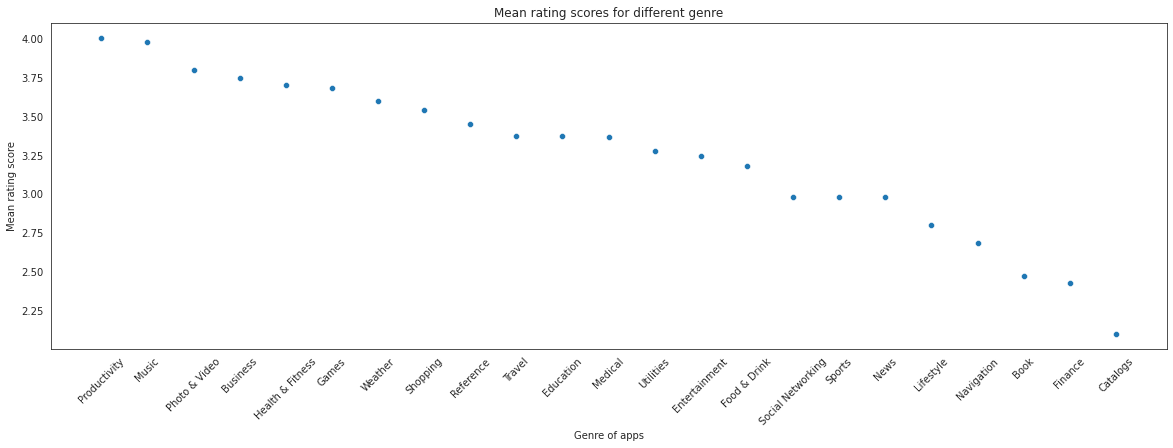

In [41]:
genre_counts=whole_data['prime_genre'].value_counts().sort_values(ascending=False)
print('genre counts for paid apps:\n{}\n'.format(genre_counts))
print('\nGenre that has the most apps is:{},and genre that has the least apps is:{}\n'.format(genre_counts.idxmax(),genre_counts.idxmin()))
mean_rating=whole_data.groupby(['prime_genre']).user_rating.mean().sort_values(ascending=False)
print("\nmean ratings for each genre are:\n{}".format(mean_rating))
print('\nGenre that has the highest average rating is:{},and genre that has the lowest average rating is:{}\n'.format(mean_rating.idxmax(),mean_rating.idxmin()))
fig,ax=plt.subplots(figsize=(20,6))
ax=sns.scatterplot(data=mean_rating)
ax.set(ylabel="Mean rating score")
ax.set(xlabel="Genre of apps")
ax.set(title="Mean rating scores for different genre")
plt.xticks(rotation=45)

There are 23 genres and we reduce genres to six for better analysis


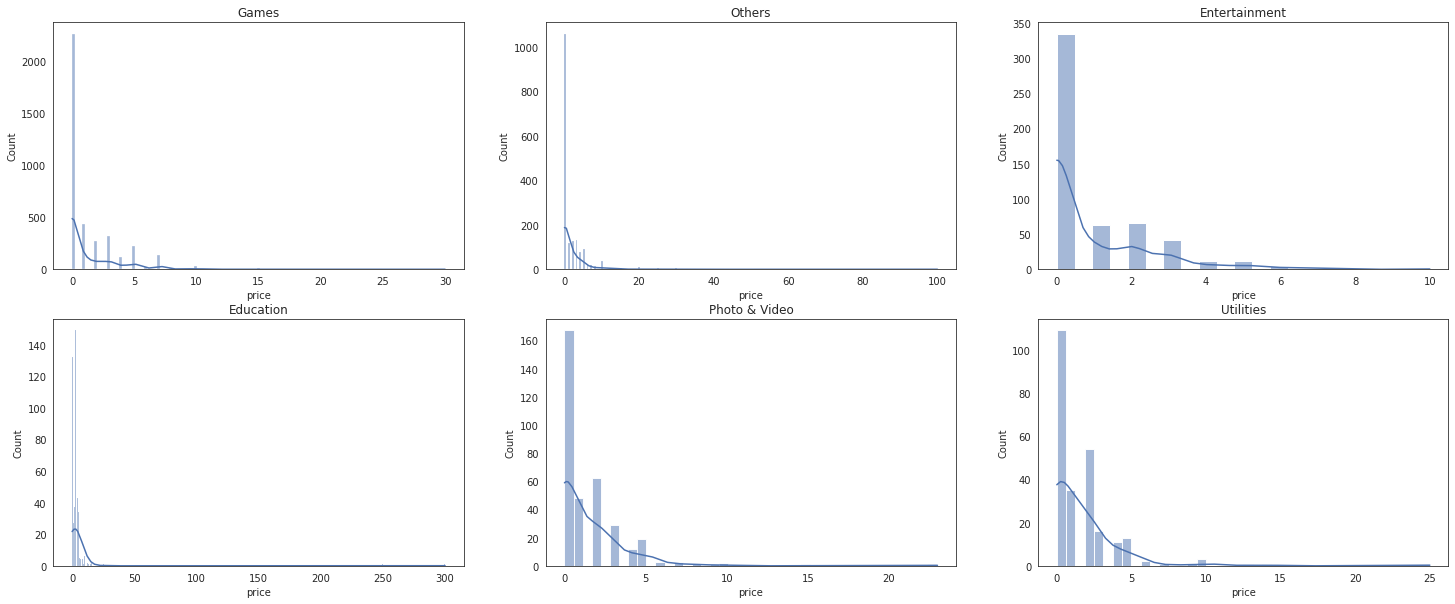

In [42]:
print('There are {} genres and we reduce genres to six for better analysis'.format(len(list(genre_counts.index))))
top_five_genres=list(genre_counts.index)[:5]
def reduce_genre(genre):
    if genre in top_five_genres:
        return genre
    else:
        return 'Others'
whole_data['reduced_genre']=whole_data['prime_genre'].apply(lambda x:reduce_genre(x))
reduced_genre=list(whole_data['reduced_genre'].value_counts(ascending=False).index)
fig,axes=plt.subplots(2,3,figsize=(25,10))
for genre,ax in zip(reduced_genre,axes.ravel()):
    data=whole_data.loc[whole_data['reduced_genre']==genre,'price']
    ax.set_title("{}".format(genre))
    sns.histplot(data, color="b",kde=True,ax=ax)

In [43]:
education_data=whole_data.loc[whole_data['reduced_genre']=='Education']
high_priced_education_apps=education_data.loc[education_data.price>=30,['track_name','price','user_rating','prime_genre','reduced_genre']].sort_values(by='price')
others_data=whole_data.loc[whole_data['reduced_genre']=='Others']
high_priced_other_apps=others_data.loc[others_data.price>=30,['track_name','price','user_rating','prime_genre','reduced_genre']].sort_values(by='price')
apps_over_30=pd.concat([high_priced_education_apps,high_priced_other_apps]).sort_values(by='price').reset_index(drop=True)
apps_over_30

,track_name,price,user_rating,prime_genre,reduced_genre
0,Anatomy & Physiology: Body Structures and Func...,34.99,4.5,Medical,Others
1,KORG Gadget,39.99,4.5,Music,Others
2,KORG Module,39.99,4.0,Music,Others
3,プチ・ロワイヤル仏和辞典（第4版）・和仏辞典（第3版）,47.99,0.0,Reference,Others
4,Cubasis 2 - Mobile Music Creation System,49.99,4.0,Music,Others
5,VPN Pro | Lifetime Proxy & Best VPN by Betternet,49.99,4.5,Business,Others
6,Articulation Station Pro,59.99,4.5,Education,Education
7,Articulation Test Center Pro,59.99,4.5,Education,Education
8,FineScanner Pro - PDF Document Scanner App + OCR,59.99,4.0,Business,Others
9,NAVIGON Europe,74.99,3.5,Navigation,Others


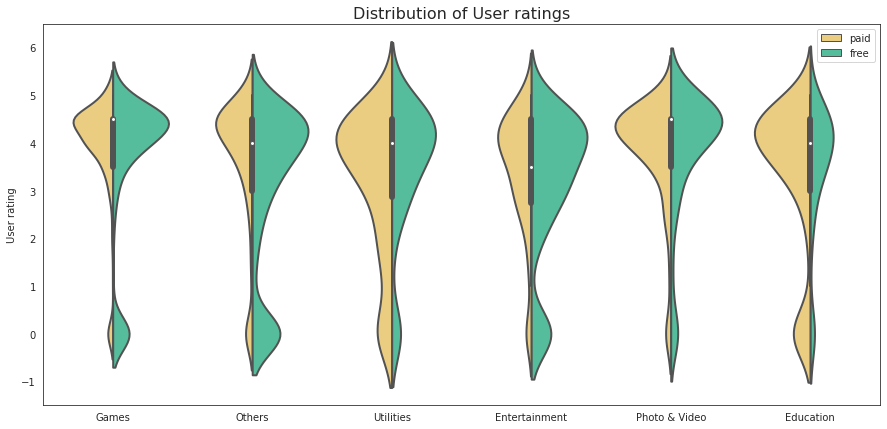

In [44]:
whole_data['ispaid']=whole_data['price']>0
whole_data['ispaid']=whole_data['ispaid'].apply(lambda x:'paid' if x==True else 'free')
fig,ax=plt.subplots(figsize=(15,7))
plt.style.use('fast')
plt.title("Distribution of User ratings",fontsize=16) 
ax=sns.violinplot(data=whole_data,x='reduced_genre',y='user_rating',hue='ispaid',orient='v',kse=False,split=True,scale='count',linewidth=2,palette=['#fdd470','#45cea2'])
plt.xlabel('')
plt.ylabel('User rating')
plt.legend()
whole_data['ispaid']=whole_data['price']>0
whole_data['ispaid']=whole_data['ispaid'].apply(lambda x:'paid' if x==True else 'free')
fig,ax=plt.subplots(figsize=(15,7))
plt.style.use('fast')
plt.title("Distribution of User ratings",fontsize=16) 
ax=sns.violinplot(data=whole_data,x='reduced_genre',y='user_rating',hue='ispaid',orient='v',kse=False,split=True,scale='count',linewidth=2,palette=['#fdd470','#45cea2'])
plt.xlabel('')
plt.ylabel('User rating')
plt.legend()

In [45]:
free = whole_data.loc[whole_data.price==0,'reduced_genre'].value_counts().reset_index()
paid = whole_data.loc[whole_data.price>0,'reduced_genre'].value_counts().reset_index()
total= whole_data.loc[:,'reduced_genre'].value_counts().reset_index()
free.columns=['genre','free_apps']
paid.columns=['genre','paid_apps']
total.columns=['genre','total_apps']
paid_free=free.merge(paid,on='genre').merge(total,on='genre')
paid_free['paid_percentage']=(paid_free['paid_apps']/paid_free['total_apps'])*100
paid_free['free_percentage']=(paid_free['free_apps']/paid_free['total_apps'])*100
paid_free

,genre,free_apps,paid_apps,total_apps,paid_percentage,free_percentage
0,Games,2257,1605,3862,41.558778,58.441222
1,Others,1057,693,1750,39.600000,60.400000
2,Entertainment,334,201,535,37.570093,62.429907
3,Photo & Video,167,182,349,52.148997,47.851003
4,Education,132,321,453,70.860927,29.139073
5,Utilities,109,139,248,56.048387,43.951613


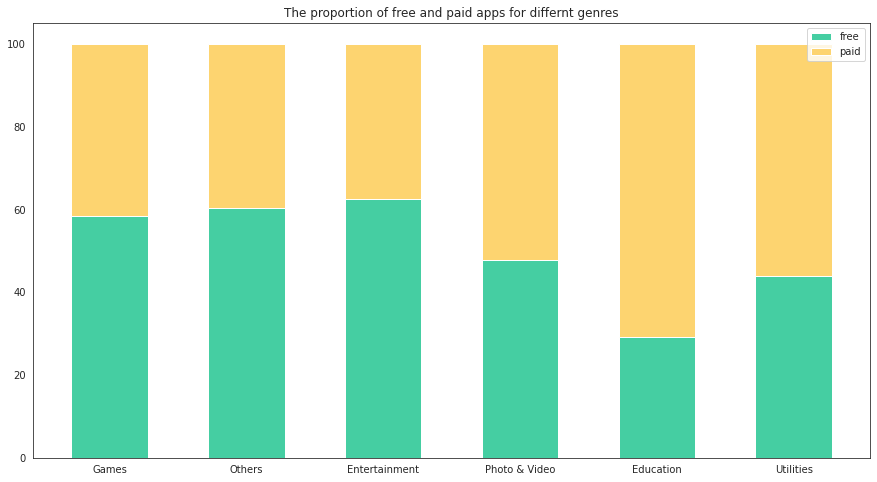

In [46]:
list_free= paid_free.free_percentage.tolist()
list_paid=paid_free.paid_percentage.tolist()

plt.figure(figsize=(15,8))
N=6
ind = np.arange(N)  
width =0.56  

p1 = plt.bar(ind, list_free, width, color='#45cea2')
p2 = plt.bar(ind, list_paid, width,bottom=list_free,color='#fdd470')
plt.xticks(ind,paid_free.genre.tolist())
plt.legend((p1[0], p2[0]), ('free', 'paid'),loc='upper right')
plt.title("The proportion of free and paid apps for differnt genres")
plt.show()

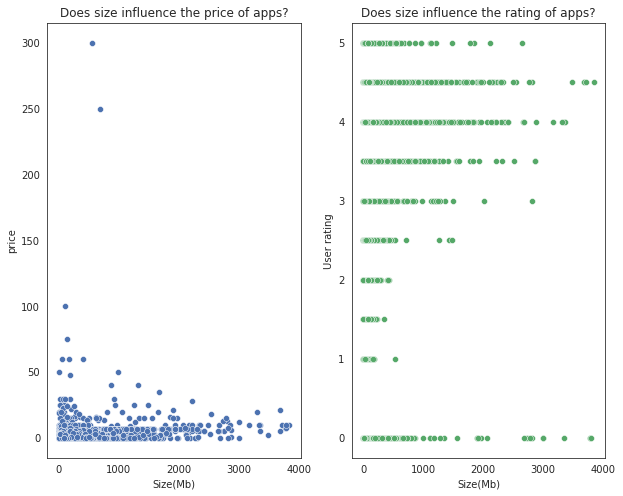

In [47]:
whole_data['size_mb']=whole_data['size_bytes']/1048576 
fig,axes=plt.subplots(1,2,figsize=(10,8))
sns.scatterplot(x='size_mb',y='price',data=whole_data,ax=axes[0],color='b')
sns.scatterplot(x='size_mb',y='user_rating',data=whole_data,ax=axes[1],color='g')
axes[0].set_title('Does size influence the price of apps?')
axes[0].set_xlabel('Size(Mb)')
axes[1].set_title('Does size influence the rating of apps?')
axes[1].set_xlabel('Size(Mb)')
axes[1].set_ylabel('User rating')

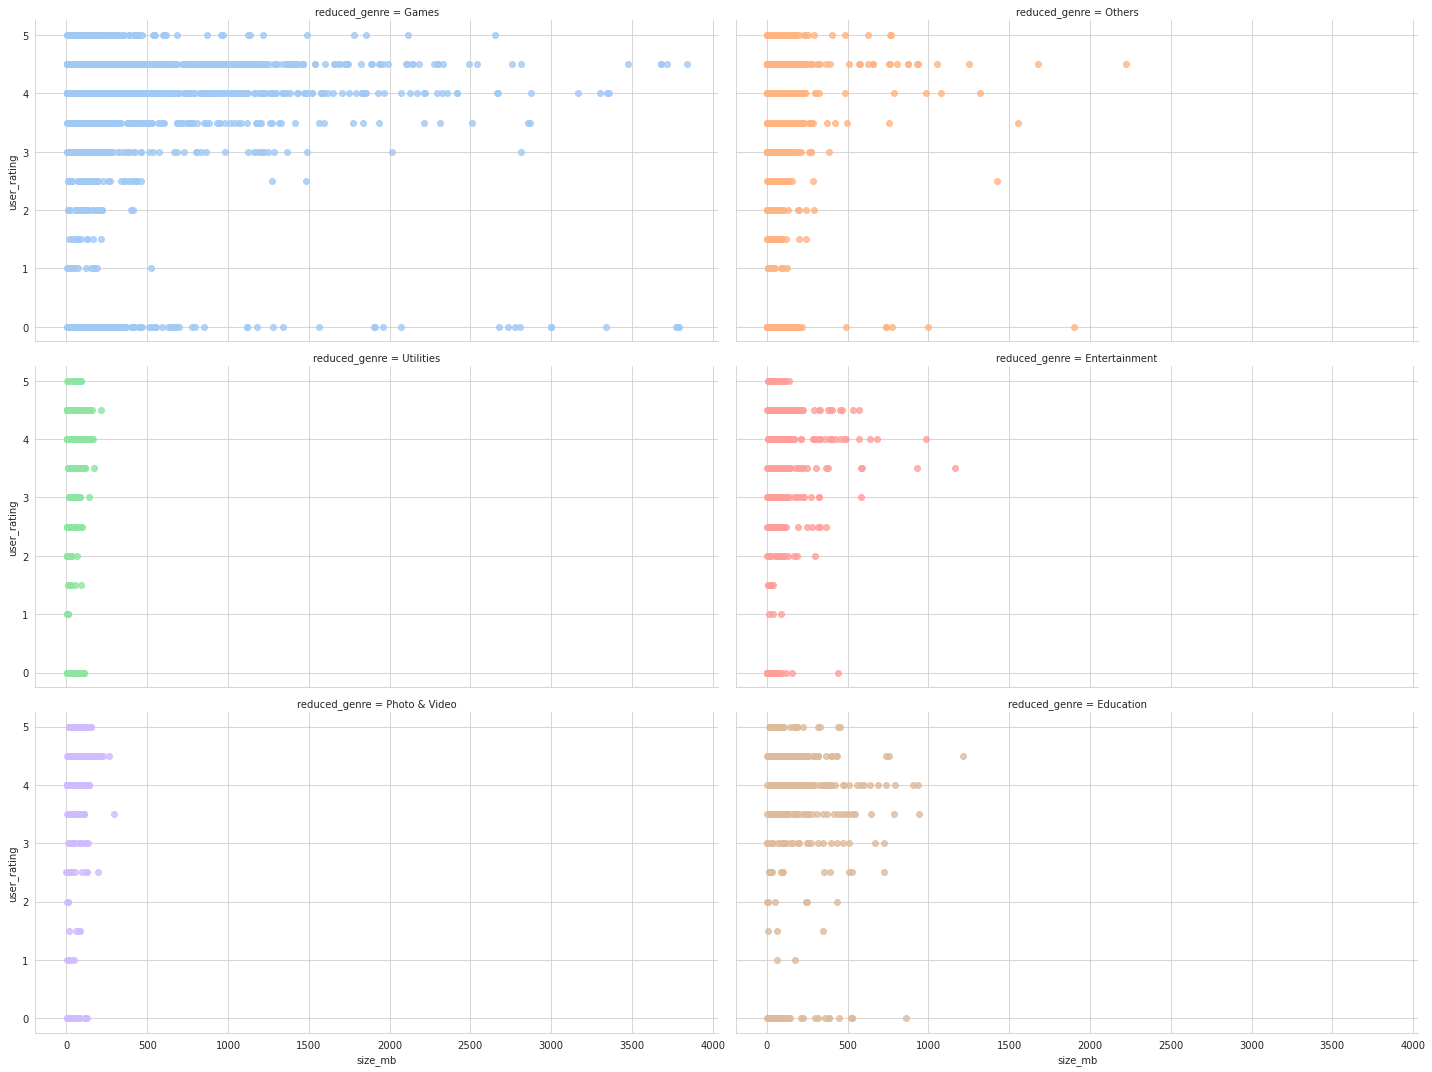

In [48]:
sns.set_style("whitegrid")
ax=sns.lmplot(data=whole_data,x='size_mb',y='price',aspect=2,col_wrap=2,hue='reduced_genre',col='reduced_genre',fit_reg=False,palette = sns.color_palette("pastel", 6))

sns.set_style("whitegrid")
ax=sns.lmplot(data=whole_data,x='size_mb',y='user_rating',aspect=2,col_wrap=2,hue='reduced_genre',col='reduced_genre',fit_reg=False,palette = sns.color_palette("pastel", 6))

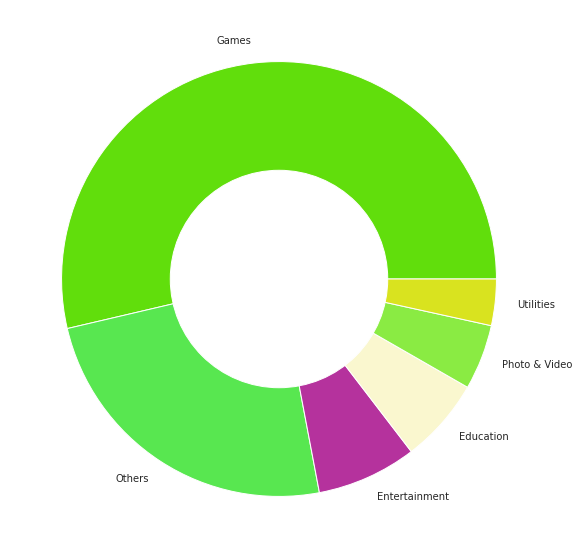

In [49]:
def random_color_generator(number_of_colors): #generate random colors
    color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
                 for i in range(number_of_colors)]
    return color

app_number_each_genre=list(whole_data['reduced_genre'].value_counts(ascending=False))
plt.figure(figsize=(10,10))
my_circle=plt.Circle( (0,0), 0.5, color='white')
plt.pie(app_number_each_genre, labels=reduced_genre, colors = random_color_generator(6))
p=plt.gcf() 
p.gca().add_artist(my_circle)
plt.show()

In [50]:
paid_free

,genre,free_apps,paid_apps,total_apps,paid_percentage,free_percentage
0,Games,2257,1605,3862,41.558778,58.441222
1,Others,1057,693,1750,39.600000,60.400000
2,Entertainment,334,201,535,37.570093,62.429907
3,Photo & Video,167,182,349,52.148997,47.851003
4,Education,132,321,453,70.860927,29.139073
5,Utilities,109,139,248,56.048387,43.951613


In [51]:
whole_data.head()

,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,app_desc,reduced_genre,ispaid,size_mb
0,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1,"SAVE 20%, now only $3.99 for a limited time!\n...",Games,paid,96.119141
1,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1,Let Evernote change the way you organize your ...,Others,free,151.232422
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,Download the most popular free weather app pow...,Others,free,95.867188
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1,The eBay app is the best way to find anything ...,Others,free,122.558594
4,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1,On more than 250 million devices around the wo...,Others,free,88.476562


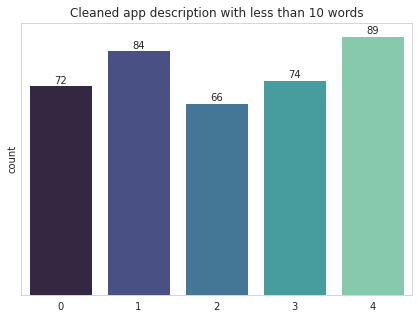

In [52]:
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions(@)
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'+'★'+'■'+'»'+'^'+'¿'+'*'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)
texts_new= []
for t in whole_data.app_desc:
    texts_new.append(remove_mult_spaces(filter_chars(strip_all_entities(t))))
whole_data['text_clean']=texts_new
# Then we check our clean text to see if we have removed to much information during data cleaning.
text_len = []
for text in whole_data.text_clean:
    tweet_len = len(text.split())
    text_len.append(tweet_len)
whole_data['text_len']=text_len

plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=whole_data.loc[whole_data['text_len']<5], palette='mako')
plt.title('Cleaned app description with less than 10 words')
plt.yticks([]) #remove yticks
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [53]:
print("rows for data before deleting:{}".format(whole_data.shape[0]))
whole_data_clean= whole_data.loc[whole_data['text_len'] > 4,:]
print("rows for data after deleting:{}".format(whole_data_clean.shape[0]))

rows for data before deleting:7197
rows for data after deleting:6812


In [54]:
whole_data.isnull().sum()
bargain=['sale','on sale','save','free','only','cheap','cheapest','bargain','lowest','low','limited']
quality=['most','popular','rated','bestselling','rating','perfect','world','winner','best','over','powerful','richest','leading','first','easiest','unlimited','better','famous']

nlp = spacy.blank('en') 
matcher = PhraseMatcher(nlp.vocab, attr='LOWER') 
bargain_tokens_list = [nlp(item) for item in bargain]
matcher.add("bargain",bargain_tokens_list) 

bargain_dumm=[]
for idx, review in whole_data_clean.iterrows():
    doc = nlp(review.text_clean) 
    # Using the matcher from the previous exercise
    matches = matcher(doc) 
    # Create a set of the items found in the review text，
    found_items =set([doc[match[1]:match[2]].text.lower() for match in matches]) 
    if len(found_items)!=0:
        bargain_dumm.append(1)
    else:
        bargain_dumm.append(0)
matcher2 = PhraseMatcher(nlp.vocab, attr='LOWER') 
quality_tokens_list = [nlp(item) for item in quality]
matcher2.add("quality",quality_tokens_list) 
quality_dumm=[]
for idx, review in whole_data_clean.iterrows():
    doc = nlp(review.text_clean) 
    matches = matcher2(doc) 
    found_items =set([doc[match[1]:match[2]].text.lower() for match in matches]) 
    if len(found_items)!=0:
        quality_dumm.append(1)
    else:
        quality_dumm.append(0)
whole_data_clean['bargain_dumm']=bargain_dumm
whole_data_clean['quality_dumm']=quality_dumm
whole_data_clean['bar_qua_sum']=whole_data_clean['bargain_dumm']+whole_data_clean['quality_dumm']
whole_data_clean['cost_effective_dumm']=whole_data_clean['bar_qua_sum']==2
whole_data_clean.drop(['bar_qua_sum'],axis=1,inplace=True)
print('There are {} descriptions involve bargain information, while {} descriptions do not involve.'.format(whole_data_clean.bargain_dumm.value_counts().tolist()[0],whole_data_clean.bargain_dumm.value_counts().tolist()[1]))
print('There are {} descriptions involve quality information, while {} descriptions do not involve.'.format(whole_data_clean.quality_dumm.value_counts().tolist()[0],whole_data_clean.quality_dumm.value_counts().tolist()[1]))
print('There are {} descriptions indicate cost effective information, while {} descriptions do not involve.'.format(whole_data_clean.cost_effective_dumm.value_counts().tolist()[0],whole_data_clean.cost_effective_dumm.value_counts().tolist()[1]))

There are 3569 descriptions involve bargain information, while 3243 descriptions do not involve.
There are 4909 descriptions involve quality information, while 1903 descriptions do not involve.
There are 3780 descriptions indicate cost effective information, while 3032 descriptions do not involve.


In [55]:
whole_data_clean.head(5)

,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,app_desc,reduced_genre,ispaid,size_mb,text_clean,text_len,bargain_dumm,quality_dumm,cost_effective_dumm
0,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1,"SAVE 20%, now only $3.99 for a limited time!\n...",Games,paid,96.119141,save 20 now only 399 for a limited time one of...,261,1,1,True
1,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1,Let Evernote change the way you organize your ...,Others,free,151.232422,let evernote change the way you organize your ...,585,1,1,True
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1,Download the most popular free weather app pow...,Others,free,95.867188,download the most popular free weather app pow...,290,1,1,True
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1,The eBay app is the best way to find anything ...,Others,free,122.558594,the ebay app is the best way to find anything ...,651,1,1,True
4,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1,On more than 250 million devices around the wo...,Others,free,88.476562,on more than 250 million devices around the wo...,456,1,1,True


In [56]:
whole_data_clean['cur_rating_per']=(whole_data_clean['rating_count_ver']/(whole_data_clean['rating_count_tot']))*100
whole_data_clean['cur_better_rating']=whole_data_clean['user_rating_ver']>whole_data_clean['user_rating']
whole_data_clean['main_version_num']=whole_data_clean['ver'].str.split(pat='.',expand=True)[0]
whole_data_clean['main_version_num']=whole_data_clean['main_version_num'].apply(lambda x: 0 if x=='0' else (1 if x=='1' else (2 if x=='2' else (3 if x=='3' else (4 if x=='4' else (5 if x=='5' else (6 if x=='6' else (7 if x=='7' else (8 if x=='8' else (9 if x=='9' else (10 if x=='10' else (11 if x=='11'else (12 if x=='12' else (13 if x=='13' else (14 if x=='14' else (15 if x=='15' else(16 if x=='16' else(17 if x=='17' else (18 if x=='18' else (19 if x=='19' else 20))))))))))))))))))))
whole_data_clean.loc[whole_data_clean['main_version_num']<20]
whole_data_clean['accu_reduced_genre']=whole_data_clean['prime_genre'].apply(lambda x: 0 if x=='Games' else (1 if x=='Entertainment' else (2 if x=='Education' else (3 if x=='Photo & Video' else (4 if x=='Utilities' else (5 if x=='Health & Fitness' else (6 if x=='Productivity' else (7 if x=='Social Networking' else (8 if x=='Music' else (9 if x=='Lifestyle' else 10))))))))))
whole_data_clean['use_screenshots']=whole_data_clean['ipadSc_urls.num']>0
whole_data_clean['only_one_language']=whole_data_clean['lang.num']==1
whole_data_clean['rating_dum']=whole_data_clean['user_rating']>=4
whole_data_clean.shape

(6812, 31)

In [57]:
df=whole_data_clean.copy()
df.drop(['track_name','currency','ver','prime_genre','app_desc','text_clean','user_rating'],axis=1,inplace=True)
df=pd.get_dummies(df).reset_index(drop=True)
df.fillna(0,axis=1,inplace=True)

In [58]:
df=whole_data_clean.copy()
df.drop(['track_name','currency','ver','prime_genre','app_desc','text_clean','user_rating'],axis=1,inplace=True)
df=pd.get_dummies(df).reset_index(drop=True)
df.fillna(0,axis=1,inplace=True)

In [ ]:
skf=StratifiedKFold(n_splits=8,shuffle=True,random_state=1)